In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras 

In [ ]:
mpath = '/content/drive/My Drive/TomatoDetection/models/tomato_classifier_2.h5' #loading and compiling the model.
model = keras.models.load_model(mpath, compile=True)

In [ ]:
cv.setUseOptimized(True);
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()


In [ ]:
def boxarea(bb):
  return (bb['x2'] - bb['x1']) * (bb['y2'] - bb['y1'])

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = boxarea(bb1)
    bb2_area = boxarea(bb2)

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
def get_iomin(bb1,bb2):
  #returns intersection area/ min of the boxes' area
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
      return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = boxarea(bb1)
  bb2_area = boxarea(bb2)

  iomin = max(intersection_area /bb1_area , intersection_area/bb2_area)
  assert iomin >= 0.0
  assert iomin <= 1.0
  return iomin

In [ ]:
def ripeorraw(image, bndboxvalues):
  labels = []
  for bnd in bndboxvalues:
    img = image[bnd['y1']:bnd['y2'],bnd['x1']:bnd['x2']]
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(image, np.array([0,65,65]), np.array([40, 255, 255])) #changes to be made: include the range  [160, 65,65] to [180,255,255] for the color red and combine the results.
    unique, counts = np.unique(mask, return_counts=True)
    final = dict(zip(unique, counts))
    try:
      score = final[255]/(mask.shape[0]*mask.shape[1])
      if score > 0.4:
        label = 'ripe tomato'
      else:
        label = 'raw tomato'
    except:
      label = 'raw tomato'
    labels.append(label)
  return labels

In [ ]:
def getROIS(image):
  #method can be improved by writing a custom roi detection function instead of using selective search. AIM: to dectect less and more accurate rois.
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rois = ss.process()
  roiims = []
  rois2 = []
  for roi in rois:
    x,y,w,h = roi
    pim = image[y:y+h,x:x+w]
    if(pim.shape[0]/pim.shape[1] >2 or pim.shape[1]/pim.shape[0] >2):
      continue
    else:
      pim2 = cv.resize(pim, (224,224), interpolation = cv.INTER_AREA)
      roiims.append(pim2)
      rois2.append(roi)
  return rois2, np.array(roiims)

In [ ]:
def getPredictions(image,rois, x):
  bndboxvalues = []
  prob =[]
  y_pred = model.predict(x)
  for i in range(y_pred.shape[0]):
    y1 = y_pred[i][0]
    if(y1>0.55):
      x,y,w,h = rois[i]
      bndbox = {'x1':x, 'x2':x+w, 'y1':y, 'y2':y+h}
      bndboxvalues.append(bndbox)
      prob.append(y1)
  return bndboxvalues, prob

In [ ]:
def trimBndBoxes(bndboxvalues, prob, imgarea):
  #using iou and iomin to delete redundant predictions
  i = 0
  while i < len(bndboxvalues):
    if(boxarea(bndboxvalues[i]) <= (imgarea/85)):
      del(bndboxvalues[i])
      del(prob[i])
      i -= 1
    else:
      j = 1+i
      while j < len(bndboxvalues):
        iou = get_iou(bndboxvalues[i],bndboxvalues[j])
        if iou > 0.17:
          if prob[j]<=prob[i]:
            del(bndboxvalues[j])
            del(prob[j])
          else:
            del(bndboxvalues[i])
            del(prob[i])
            i -=1
            break;
        else:
          iomin = get_iomin(bndboxvalues[i],bndboxvalues[j])
          if iomin > 0.4:
            if prob[j]<=prob[i]:
              del(bndboxvalues[j])
              del(prob[j])
            else:
              del(bndboxvalues[i])
              del(prob[i])
              i -=1
              break;
          else:
            j+=1 
    i+= 1
  return bndboxvalues

In [ ]:
def readimg(imagename):
  impath = '/content/drive/My Drive/TomatoDetection/images/' + imagename +'.png'
  return cv.imread(impath)

In [ ]:
def detectTomatoes(imgname):
  image = readimg(imgname)
  # dim =(int(image.shape[1]/5), int(image.shape[0]/5,))
  # image = cv.resize(image, dim)
  # print(image.shape)
  imgarea = image.shape[0]*image.shape[1]
  rois, roi_ims = getROIS(image)
  bndboxes, probs = getPredictions(image, rois, roi_ims)
  bndboxestrimmed = trimBndBoxes(bndboxes, probs,imgarea)

  labels = ripeorraw(image, bndboxestrimmed)

  fig = plt.figure()
  ax = fig.add_axes([0, 0, 1, 1])
  plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))
  for i in range(len(bndboxestrimmed)):
    bnd = bndboxestrimmed[i]
    rect = patches.Rectangle((bnd['x1'], bnd['y1']), (bnd['x2']-bnd['x1']), (bnd['y2']- bnd['y1']), edgecolor='blue', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.text(bnd['x1'], bnd['y1'], labels[i], color='blue')
  
  return bndboxestrimmed



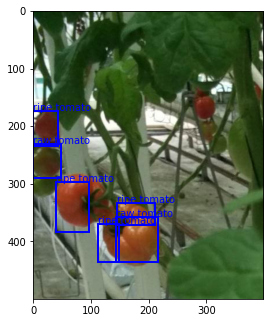

In [ ]:
bndboxes = detectTomatoes('tomato0')

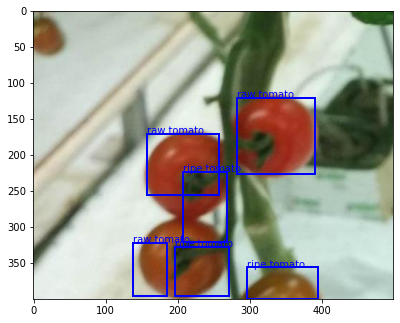

In [ ]:
bndboxes = detectTomatoes('tomato241')

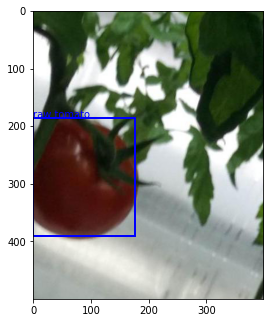

In [ ]:
bndboxes = detectTomatoes('tomato32')

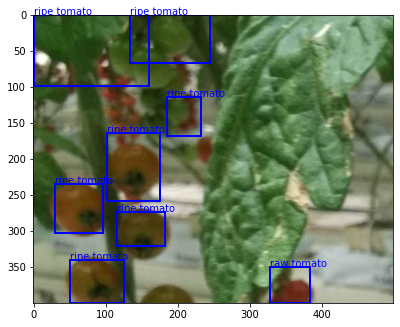

In [ ]:
bndboxes = detectTomatoes('tomato50')

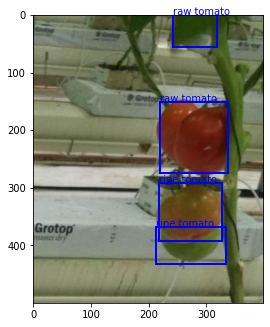

In [ ]:
bndboxes = detectTomatoes('tomato456')

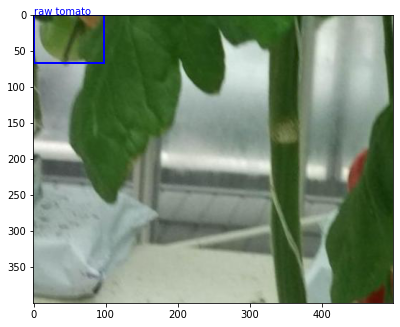

In [ ]:
bndboxes = detectTomatoes('tomato666')

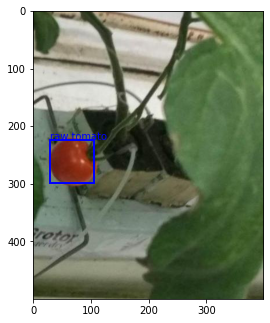

In [ ]:
bndboxes = detectTomatoes('tomato800')